In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import style_transfer.vgg as vgg
import torch
from torch.autograd import Variable

/Applications/anaconda/envs/ulab/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


# Overview

We learned in the previous notebook how you can use the Pytorch autograd package to calculate the gradients of variables. In this notebook we will go over key concepts in how gradients are used in style transfer. This will include:

* Models
* Loss functions
* Gradient descent

We will focus on loss functions and gradient descent. For the purpose of this notebook, we will treat the VGG neural network as a black box with only a brief overview of what they are. 

We'll call it a "model".

In deep learning, a computer model learns information* directly from images, text, or sound. Deep learning models can achieve state-of-the-art accuracy, sometimes exceeding human-level performance. Models are trained by using a large set of labeled data and neural network architectures that contain many layers.



In [4]:
vgg_model, style_image, content_image, opt_img = vgg.init()

# Loss Functions

We have:
- $\texttt{vgg}$: We will not be focusing on what $\texttt{vgg}$ is in this notebook, but we will provide a general overview. $\texttt{vgg}$ takes in an input image ($\texttt{opt_img}$) and feeds it through sequential layers of the model. The output of the previous layer is the input of the next layer, and so on. The main purpose of $\texttt{vgg}$ is to help quantify the style of $\texttt{opt_img}$.
- $\texttt{content_img}$: We want the end result to be similar in $\textbf{content}$ with this image (i.e. houses, river)

<img src="Images/Tuebingen_Neckarfront.jpg" width="423">
<img src="Images/vangogh_starry_night.jpg" width="400">


- $\texttt{style_img}$: We want the end result to be similar in $\textbf{style}$ with this image. (i.e. impressionist  style, curly sky)
- $\texttt{opt_img}$: The image we are trying to change so that it fits both the content of $\texttt{content_img}$ and the style of $\texttt{style_img}$

Style transfer is an iterative process. Every iteration, we adjust the image slightly to be closer to the style of the style image, while retaining most of the content. Now, how do we quantify how close $\texttt{opt_img}$ is compared to the style and content images?

### Exercise 1

Given two images, A and B of the same size (i.e. both 28 x 28 pixels). Can you think of a method to calculate the distance between both images? Your solution doesn't have to be exact. The distance should be able to quantify some kind of difference between two images. $\textit{Hint: What are different ways to measure the distance between two vectors?}$

In [5]:
"""
Describe your method here: ANSWER HERE
"""

def dist(A, B):
    return torch.sum(torch.abs(A-B))

In [6]:
A = torch.zeros(28, 28)
B = torch.zeros(28, 28)
print(dist(A, B))

C = torch.ones(28, 28)
print(dist(B, C))

0.0
784.0


A common way to measure the difference between any two matrices of the same size is to use Mean-Squared Error (MSE). In our case, we want to minimize the distance between our starting image $\texttt{opt_img}$ and the "true" stylized image, so distance between these two images is the same as loss (or error). Let $A$, $B$ be two $m\times n$ matrices, then
$$\text{MSE} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n (A_{ij}-B_{ij})^2$$
MSE gives a general sense of distance in that it measure the average distance between each corresponding entry of $A$ and $B$.

### Exercise 2
Given two matrices $A$, $B$, calculate the MSE (as defined above) without using any for loops. Note that the input is two torch tensors, so you should be using torch functions.

In [7]:
import torch.autograd as autograd
def calculate_mse(A, B):
    loss = torch.nn.MSELoss()
    a = autograd.Variable(A, requires_grad=True)
    b = autograd.Variable(B)
    result = loss(a,b)
    return result.data[0]

In [8]:
m, n = 10, 20
A, B = torch.rand(m, n), torch.rand(m, n)
actual = calculate_mse(A, B)

expected = sum([sum([(A[i, j] - B[i, j]) ** 2 for j in range(n)]) for i in range(m)])/(m*n)
print("expected", expected)
if np.allclose(actual, expected):
    print('Passed')
else:
    print('Failed')

expected 0.19461128113030546
Passed


Now, let's take a look at a part of the style transfer code. $\texttt{nn.MSELoss}$ does exactly what we calculated above. It takes as input 2 matrices, and calculates the MSE between them. 


#### The Gram Matrix is a way to measure the style of an image. (We will get more in-depth later)
In this case, $\texttt{GramMSELoss}$ calculates the MSE between a Gram matrix and a target Gram matrix. 

In [9]:
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(vgg.GramMatrix()(input), target)
        return(out)

### Defining the Loss Function for Style Transfer

Remember that in style transfer, we want $\texttt{opt_img}$ to be similar in style to the style image, but also retain the original content. So, our loss will consist of a combination of both.
$$\text{Loss}_{total} = \text{Loss}_{content} + \text{Loss}_{style}$$

The loss functions for style transfer are created in the code below.

In [10]:
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [vgg.GramMatrix()(A).detach() for A in vgg_model(style_image, style_layers)]
content_targets = [A.detach() for A in vgg_model(content_image, content_layers)]
targets = style_targets + content_targets

# Gradient Descent

To explain Gradient Descent we’ll use the classic mountaineering example.

Suppose you are at the top of a mountain, and you have to reach a lake which is at the lowest point of the mountain (a.k.a valley). A twist is that you are blindfolded and you have zero visibility to see where you are headed. So, what approach will you take to reach the lake?

<img src="tutorial_img/grad_desc1.png">

The best way is to check the ground near you and observe where the land tends to descend. This will give an idea in what direction you should take your first step. If you follow the descending path, it is very likely you would reach the lake. Now, to be more efficient, it would be nice to follow the steepest descent direction! From math, we know that the gradient (or slope) represents the steepness of the graph. Then, if we follow the opposite of direction of the gradient, then we can follow the steepest descent direction!

<img src="tutorial_img/vector_calculus.png">

Now that we have a way to measure the loss, the next step is the find some new $\texttt{opt_img}$ that decreases the loss. We can do this by adjusting $\texttt{opt_img}$ in the direction opposite of the gradient. In order to give some intuition into how gradient descent works, we will provide a short demo

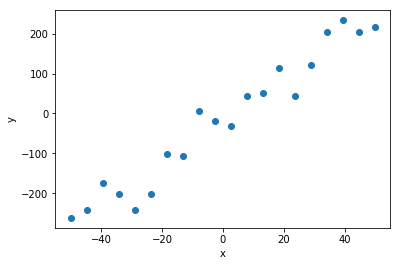

In [11]:
xs = np.linspace(-50, 50, 20)
ys = xs * 5 + np.random.randn(len(xs)) * 50
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(xs, ys)

We want to estimate a function $f(x) = wx$ that best fits the data. We define best fit by the model that minimizes the MSE, where
$$MSE = \frac{1}{20}\sum_{i=1}^{20} (y_i - f(x_i))^2$$
where $x_i = xs[i]$ and $y_i = ys[i]$. We want to find the optimal $w$ (slope) that minimizes the MSE. Note that we assume that the y-intercept is 0. Gradient descent is the process of iteratively modifying your parameters ($w$) to minimize some function - in this case MSE. The line we want to fit iteratively will progress like this (except in our case, we will fix the y-intercept to be 0).

<img src="tutorial_img/gradient_descent_example.gif">

In [12]:
def f(xs, w):
    return xs * w

def loss(xs, ys, w):
    return 1/20 * np.sum((ys - f(xs, w)) ** 2)

### Question 3
The derivative $\frac{\partial MSE}{\partial w}$ can help tell us how to adjust $w$ in order to minimize loss. Calculate and implement the derivative of MSE. $\textit{Hint: Use the above formula, substitute in $f(x_i) = wx_i$ and take the derivative with respect to $w$}$

$$MSE = \frac{1}{20}\sum_{i=1}^{20} (y_i - f(x_i))^2$$

In [42]:

def grad(xs, ys, w):
    """ Your Code Here - Try to vectorize your solution! (but it's alright if you dont)"""
    xs = Variable(torch.from_numpy(xs), requires_grad=True)
    ys = Variable(torch.from_numpy(ys), requires_grad=True)
    w = Variable(torch.DoubleTensor([w]),requires_grad = True)
    result = loss(xs,ys,w)
    return result.grad

In [43]:
def grad_check():
    delta = 1e-8
    w = 2.5
    actual_grad = grad(xs, ys, w)
    num_grad = (loss(xs, ys, w+delta) - loss(xs, ys, w)) / delta
    #print(num_grad)
    if np.allclose(num_grad, grad(xs, ys, w)):
        print('actual = ', actual_grad)
        print('Passed - Error: %s' % abs(actual_grad - num_grad))
    else:
        print('actual = ', actual_grad)
        print('Failed - Error: %s' % abs(actual_grad - num_grad))
grad_check()

RuntimeError: sum() received an invalid combination of arguments - got (out=NoneType, dtype=NoneType, axis=NoneType, ), but expected one of:
 * (int dim, bool keepdim)
 * ()


Execute the code below to show a plot of $w$ vs $MSE$. See how we want to change $w$ in the direction $\textbf{opposite}$ to the derivative. We want to increase $w$ if the derivative is negative and decrease $w$ if it is positive. The classic analogy is rolling a ball down a valley - the ball will follow the steepest descent and eventually come to a stop at the base of the valley. This motivates the idea that our update is $w_{new} = w_{old} - \alpha\frac{\partial MSE}{\partial w}$, where $\alpha$ is some small number to limit the amount that we step.

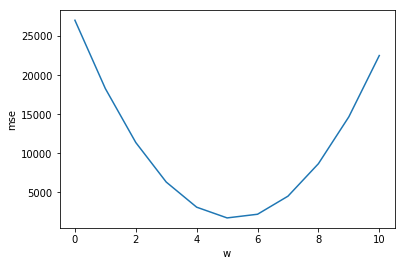

In [44]:
ws = np.linspace(0,10,11)
losses = [loss(xs, ys, w) for w in ws]
plt.xlabel('w')
plt.ylabel('mse')
plt.plot(ws, losses)

Here's a demo to show you gradient descent at work. The figure on the left is the data + the current model you have. The figure on the right shows $w$ on the x-axis and loss on the y-axis. We want $w$ that minimizes loss, which is at the true $w = 5$. The points represent the current $w$ values of each iteration - see how it is approaching the minimum. Make sure you understand how the gradient descent code below works. You can ignore the parts about plotting.

In [45]:
# Just some code to help with plotting - you can ignore this
def update(xs, ys, w):
    preds = xs * w
    f, (ax1, ax2) = plt.subplots(1, 2)
    plt.gcf()
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.scatter(xs, ys)
    ax1.plot(xs, preds)
    ax2.plot(ws, losses)
    ax2.scatter(w_prev, loss_prev)
    ax2.set_xlabel('w')
    ax2.set_ylabel('loss (mse)')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)

AttributeError: 'function' object has no attribute 'clear_output'

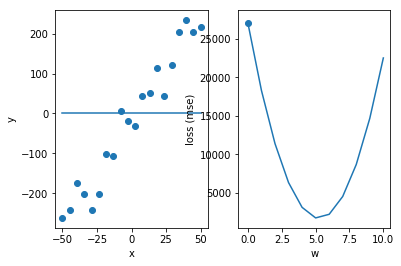

In [47]:
iters = 10
w = 0

w_prev = [w]
loss_prev = [loss(xs, ys, w)]
update(xs, ys, w)

step_size = 0.0001 # Try changing this to 0.001, 0.01, 0.1, 1 and see what happens!

for i in range(iters):
    g = grad(xs, ys, w)
    w = w - step_size * g 
    
    w_prev.append(w)
    loss_prev.append(loss(xs, ys, w))
    update(xs, ys, w)

### Make sure you understand this next part! It is very important in Style Transfer

In the previous example, all we did was iteratively adjust $w$ in the direction that minimized loss. However, what would would happen if we kept $w$ fixed and adjusted the $x$ values (our input) to minimize loss? Try running the demo below and see what happens!

In [ ]:
def grad_x(xs, ys, w):
    # Calculates the derivaative of MSE with respect to each x-value, returns a vector of length 20 (one for each data point)
    return -1/10 * (ys - w * xs) * w

## Question 4

Can you explain what is happening in the demo below? How can you relate this to MSE and $f(x)$? What line is the data being fit to? Why?

In [ ]:
w = 2.5
xs = np.linspace(-50, 50, 20)
ys = xs * 5 + np.random.randn(len(xs)) * 100
step_size = 0.25

for i in range(iters):
    g = grad_x(xs, ys, w)
    xs = xs - step_size * g 
    
    preds = xs * w
    fig = plt.figure()
    plt.gcf()
    plt.scatter(xs, ys)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)

$\textbf{This is exactly what style transfer is doing! We are trying to optimize our input image to decrease the loss}$

### Gradient Descent in Style Transfer

In style transfer, we will be performing gradient descent on $\texttt{opt_img}$ by treating the image as a set of parameters. One iteration of the gradient descent code is below. Can you identifty the different parts of gradient descent?

In [ ]:
def gd():
    def closure():
        optimizer.zero_grad() # Zeros out all the gradients - this is necessary because gradients from previous iterations will accumulate
        out = vgg(opt_img, loss_layers) # Run 
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)] # Calculate the loss
        loss = sum(layer_losses) # Calculate the loss
        loss.backward() # Calculate the gradients
        n_iter[0]+=1
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data[0]))
        return loss
    
    optimizer.step(closure) # Adjust the parameters in the direction of decreasing loss

In [ ]:
max_iter = 50
show_iter = 2
optimizer = optim.LBFGS([opt_img]); # The parameters are the values of the input image
n_iter=[0]

while n_iter[0] <= max_iter:
    gd()

In [ ]:
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

Please let us know if you have any questions about the gradient descent code above!